In [4]:
import pandas as pd
import matplotlib.pyplot as plt

In [42]:
# path = '../datasets/position_data.csv'
# path = '../datasets/virtual_data_example_pkg.csv'
# path = '../datasets/virtual_data_1.csv'
path = './data.csv'

data = pd.read_csv(path)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   x         20000 non-null  float64
 1   y         20000 non-null  float64
 2   pitch     20000 non-null  float64
 3   shoulder  20000 non-null  float64
 4   elbow     20000 non-null  float64
 5   wrist     20000 non-null  float64
dtypes: float64(6)
memory usage: 937.6 KB


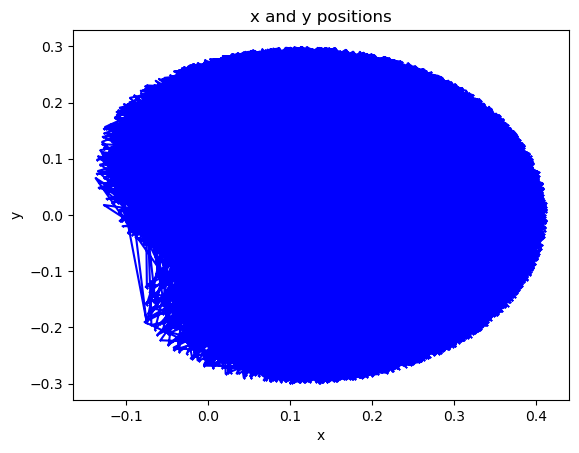

In [43]:
plt.plot(data['x'], data['y'], marker='x', color='blue', markersize=1)

plt.title('x and y positions')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

## Splitting the Data

In [44]:
from sklearn.model_selection import train_test_split
X = data[['x','y','pitch']].to_numpy()
y = data[['shoulder','elbow','wrist']].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Defining and Training a Model with PyTorch

In [45]:
import torch
from torch import nn, optim

class MLPModel(nn.Module):
    def __init__(self):
        super(MLPModel, self).__init__()
        self.hidden_layer = nn.Linear(3, 100, bias=1)
        self.output_layer = nn.Linear(100, 3)
        self.activation_function = nn.Tanh()

    def forward(self, x):
        x = self.activation_function(self.hidden_layer(x))
        x = self.output_layer(x)
        return x


def train_one_epoch(dataloader, model, optimizer, mse):
    # the running loss is the mean of the losses accumulated
    # from a batch
    running_loss = 0
    last_loss = 0
    for batch_idx, (inputs, targets) in enumerate(dataloader):
        # zero out the gradients
        optimizer.zero_grad()
        
        outputs = model(inputs)
        
        # computes the loss and its gradients
        loss = mse(outputs, targets)
        loss.backward()
        
        # adjust weights
        optimizer.step()
        
        running_loss += loss.item()
        # every 1000 batches, compute the mean of the loss
        if batch_idx % 1000 == 999:
            # compute the mean of the running_loss
            last_loss = running_loss / 1000
            print(f'  batch {batch_idx} loss: {last_loss}')
            running_loss = 0.
    
    return last_loss

In [48]:
from torch.utils.data import TensorDataset, DataLoader

# Training loop
model = MLPModel()

# transforming data into tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test,   dtype=torch.float32)
y_test_tensor = torch.tensor(y_test,   dtype=torch.float32)

dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

dataloader = DataLoader(dataset,       batch_size=4, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)


mse = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

epochs = 100

for epoch in range(epochs):
    print(f'Epoch: {epoch+1}')
    model.train(True)
    avg_loss = train_one_epoch(dataloader, model, optimizer, mse)

    running_vloss = 0

    model.eval()

    with torch.no_grad():
        for i, vdata in enumerate(test_dataset):
            vinputs, vlabels = vdata
            voutputs = model(vinputs)
            vloss = mse(voutputs, vlabels)
            running_vloss += vloss
    
    avg_vloss = running_vloss / (i + 1)
    print(f'LOSS train {avg_loss} valid {avg_vloss}')

    print(f"Epoch [{epoch + 1}/{epochs}], Loss: {running_vloss / len(dataloader):.4f}")


Epoch: 1
  batch 999 loss: 1.0169130875915289
  batch 1999 loss: 0.9181321322321891
  batch 2999 loss: 0.8802516161575913
  batch 3999 loss: 0.8665538013279438
LOSS train 0.8665538013279438 valid 0.8759682774543762
Epoch [1/100], Loss: 0.8760
Epoch: 2
  batch 999 loss: 0.8831738030016423
  batch 1999 loss: 0.8798160646110773
  batch 2999 loss: 0.8605269351452589
  batch 3999 loss: 0.8525394633710385
LOSS train 0.8525394633710385 valid 0.862469494342804
Epoch [2/100], Loss: 0.8625
Epoch: 3
  batch 999 loss: 0.8690819364190102
  batch 1999 loss: 0.8642707022503019
  batch 2999 loss: 0.8428107844814658
  batch 3999 loss: 0.8330897718071938
LOSS train 0.8330897718071938 valid 0.8405073881149292
Epoch [3/100], Loss: 0.8405
Epoch: 4
  batch 999 loss: 0.8472444207370281
  batch 1999 loss: 0.8388930339738727
  batch 2999 loss: 0.815900785908103
  batch 3999 loss: 0.8054876173734665
LOSS train 0.8054876173734665 valid 0.811892569065094
Epoch [4/100], Loss: 0.8119
Epoch: 5
  batch 999 loss: 0.81

## Defining and Training the Model with Scikit Learn

In [26]:
from sklearn.neural_network import MLPRegressor

model = MLPRegressor(
    hidden_layer_sizes=(100,),
    activation='tanh',
    max_iter=500,
    warm_start=True
)

model.fit(X_train, y_train)

MLPRegressor(activation='tanh', max_iter=500, warm_start=True)

In [27]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(model, X_test, y_test, cv=5, scoring='neg_mean_squared_error')
print("Cross-validation scores:", -scores)  # Negate scores to get MSE
# Print the mean and standard deviation of the scores
print("Mean MSE:", -scores.mean())
print("Std. dev. of MSE:", scores.std())

/home/xavier/miniconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/xavier/miniconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Cross-validation scores: [0.87315703 0.48160248 0.42741962 0.8547205  0.90548295]
Mean MSE: 0.7084765142383539
Std. dev. of MSE: 0.20870233221369536


In [28]:
from joblib import dump, load
 
# Save the model weights
#dump(model, "mlp_regressor_weights_2.joblib")
#print("Model weights saved")

# load the model later
# loaded_model = load("mlp_regressor_weights.joblib")
# print("Model weights loaded")